# [ KUIAI, AI해커톤 ] 데이터셋2_용해탱크 AI 데이터 분석
- 주관 및 지원 : 고려대학교, 한국산업기술진흥원, 한국전자연구기술원 
- 후원 : TachYon Tech
- 팀명 : White-box
- 팀원 : 한양대학교 ERICA 고유미, 노지영, 유동완, 이시현


# [용해탱크]

### 공정 개요
-  원료를 시차를 두고 순차적으로 투입 
   - 투입시마다 내용물의 상태에 변화 발생
   - 시계열로 이루어진 데이터 / 순서 의존성 유지

- 원료 용해 시 너무 낮은 온도와 느린 교반속도는 용해에 문제를 발생
 - 단, 무작정 올린 온도와 속도 또한 용해에 영향을 미침
  
- 모든 요인변수는 용해 내용량(중량)에 의해 영향을 받음
  
  
###용해상태에 영향을 미치는 요인

 - 용해 온도(MELT_TEMP)
 - 교반 속도(MOTORSPEED)
 - 내용량(INSP: 생산품의 수분함유량)

## 단계 1. 라이브러리 및 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import scipy 
from sklearn.ensemble import IsolationForest 

## 단계2. 데이터 특성 파악 및 전처리

### 2-1 데이터 기본 구조 파악

In [ ]:
df = pd.read_csv('melting_tank.csv')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


### 2-2 분석에 활용할 칼럼 추출

- 'df’에서 실제 분석에 활용할 독립변수, 종속변수를 제외한 나머지 변수들을 제거한다

In [ ]:
df.drop(['STD_DT','NUM','MELT_WEIGHT'],axis=1, inplace=True)

### 2-3 범주형 변수를 숫자 형태로 인코딩해주는 과정

 - 종속변수인 TAG가 범주형(OK, NG) 형태로 되어있기 때문에 해당 변수를 숫자 형태로 인코딩 해주어야함
   (기계는 문자열을 인식하지 못하기 때문에 숫자 형태로 변환 필요)

In [ ]:
df.loc[df['TAG']== "NG", "TAG"] = 1
df.loc[df['TAG']== "OK", "TAG"] = 0
df['TAG'] = df['TAG'].astype(int)

### 2-4. 양품과 불량품에 따른 데이터 분류

In [ ]:
# 양품
tag_Y = df[df['TAG']==0]

# 불량
tag_N = df[df['TAG']==1]

In [ ]:
pd.DataFrame(tag_Y)

,MELT_TEMP,MOTORSPEED,INSP,TAG
0,489,116,3.19,0
1,433,78,3.19,0
2,464,154,3.19,0
3,379,212,3.19,0
4,798,1736,3.21,0
...,...,...,...,...
835195,755,1743,3.21,0
835196,385,206,3.19,0
835197,465,148,3.20,0
835198,467,0,3.19,0


In [ ]:
# 양품
tag_Y_X = tag_Y.drop(['TAG'] ,axis=1)
tag_Y_y = pd.DataFrame(tag_Y['TAG'])

# 불량
tag_N_X = tag_N.drop(['TAG'] ,axis=1)
tag_N_y =  pd.DataFrame(tag_N['TAG'])

In [ ]:
tag_Y_X

,MELT_TEMP,MOTORSPEED,INSP
0,489,116,3.19
1,433,78,3.19
2,464,154,3.19
3,379,212,3.19
4,798,1736,3.21
...,...,...,...
835195,755,1743,3.21
835196,385,206,3.19
835197,465,148,3.20
835198,467,0,3.19


### 2-5. MinMax 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(tag_Y_X)
scaler.fit(tag_N_X)

tag_Y_X_s = scaler.transform(tag_Y_X)
tag_N_X_s = scaler.transform(tag_N_X)

In [ ]:
tag_Y_X_s_pd = pd.DataFrame(tag_Y_X_s, columns=tag_Y_X.columns)

tag_N_X_s_pd = pd.DataFrame(tag_N_X_s, columns=tag_N_X.columns)

In [ ]:
tag_Y_X_s_pd

,MELT_TEMP,MOTORSPEED,INSP
0,0.732794,0.429630,0.50
1,0.506073,0.288889,0.50
2,0.631579,0.570370,0.50
3,0.287449,0.785185,0.50
4,1.983806,6.429630,1.00
...,...,...,...
658128,1.809717,6.455556,1.00
658129,0.311741,0.762963,0.50
658130,0.635628,0.548148,0.75
658131,0.643725,0.000000,0.50


### 2-6. 훈련/테스트 데이터 분리

In [ ]:
import pandas as pd

# 양품 데이터 내에서, train, test 구분

X_train = tag_Y_X_s_pd.iloc[:300000]
y_train = tag_Y_y.iloc[:300000]

tag_test_Y_x = tag_Y_X_s_pd.iloc[300000:]
tag_test_Y_y = tag_Y_y.iloc[300000:]

# 불량 데이터는 모조리 test로 
tag_test_N = tag_N_X

X_test = pd.concat([tag_test_Y_x,tag_test_N])

y_test = pd.concat([tag_test_Y_y, tag_N_y ])

print('CN7의 양품 학습 데이터셋 개수:', len(X_train))
print('CN7의 양품 검증 데이터셋 개수:', len(tag_test_Y_x))
print('CN7의 불량 검증 데이터셋 개수:', len(tag_test_N))

CN7의 양품 학습 데이터셋 개수: 300000
CN7의 양품 검증 데이터셋 개수: 358133
CN7의 불량 검증 데이터셋 개수: 177067


In [ ]:
tag_test_Y_x

,MELT_TEMP,MOTORSPEED,INSP
300000,0.769231,0.529630,0.50
300001,0.627530,0.611111,0.50
300002,1.672065,6.385185,1.25
300003,1.842105,6.437037,1.25
300004,0.728745,0.603704,0.50
...,...,...,...
658128,1.809717,6.455556,1.00
658129,0.311741,0.762963,0.50
658130,0.635628,0.548148,0.75
658131,0.643725,0.000000,0.50


## 단계3. 모델 실행 및 평가

### 3-1. Isolation Forest 모델 구축

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0, random_state=None, n_jobs=-1)

In [ ]:
import time 
start = time.time()

clf.fit(X_train)
pred_outlier = clf.predict(X_test)

print(time.time()-start)

11.433677911758423


In [ ]:
pred_outlier = pd.DataFrame(pred_outlier).replace({1:0, -1:1})

### 3-2. 모델 훈련 및 평가

confusion matrix
 [[321371      0]
 [ 36762 177067]]
Accuracy:  0.9313116591928251
classification_report
               precision    recall  f1-score   support

           0       0.90      1.00      0.95    321371
           1       1.00      0.83      0.91    213829

    accuracy                           0.93    535200
   macro avg       0.95      0.91      0.93    535200
weighted avg       0.94      0.93      0.93    535200

Auc Score :  0.9140387880034981


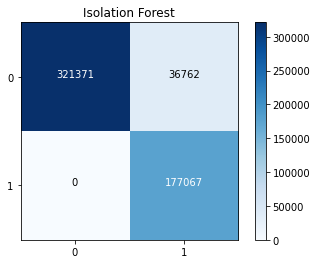

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import itertools

class_name = [0,1]
def plot_confusion_matrix(classes, pred, y_test, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


# 평가
print('confusion matrix\n', confusion_matrix(pred_outlier, y_test))
print('Accuracy: ',accuracy_score(pred_outlier,y_test))
print('classification_report\n', classification_report(pred_outlier, y_test))
print('Auc Score : ', roc_auc_score(pred_outlier, y_test))
plot_confusion_matrix(class_name, pred_outlier, y_test, title='Isolation Forest')